# Primer punto del parcial 
Mariana Castañeda y Shadia Jaafar

In [10]:
import mglearn
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold

In [3]:
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)

## Grid Search y Pipeline

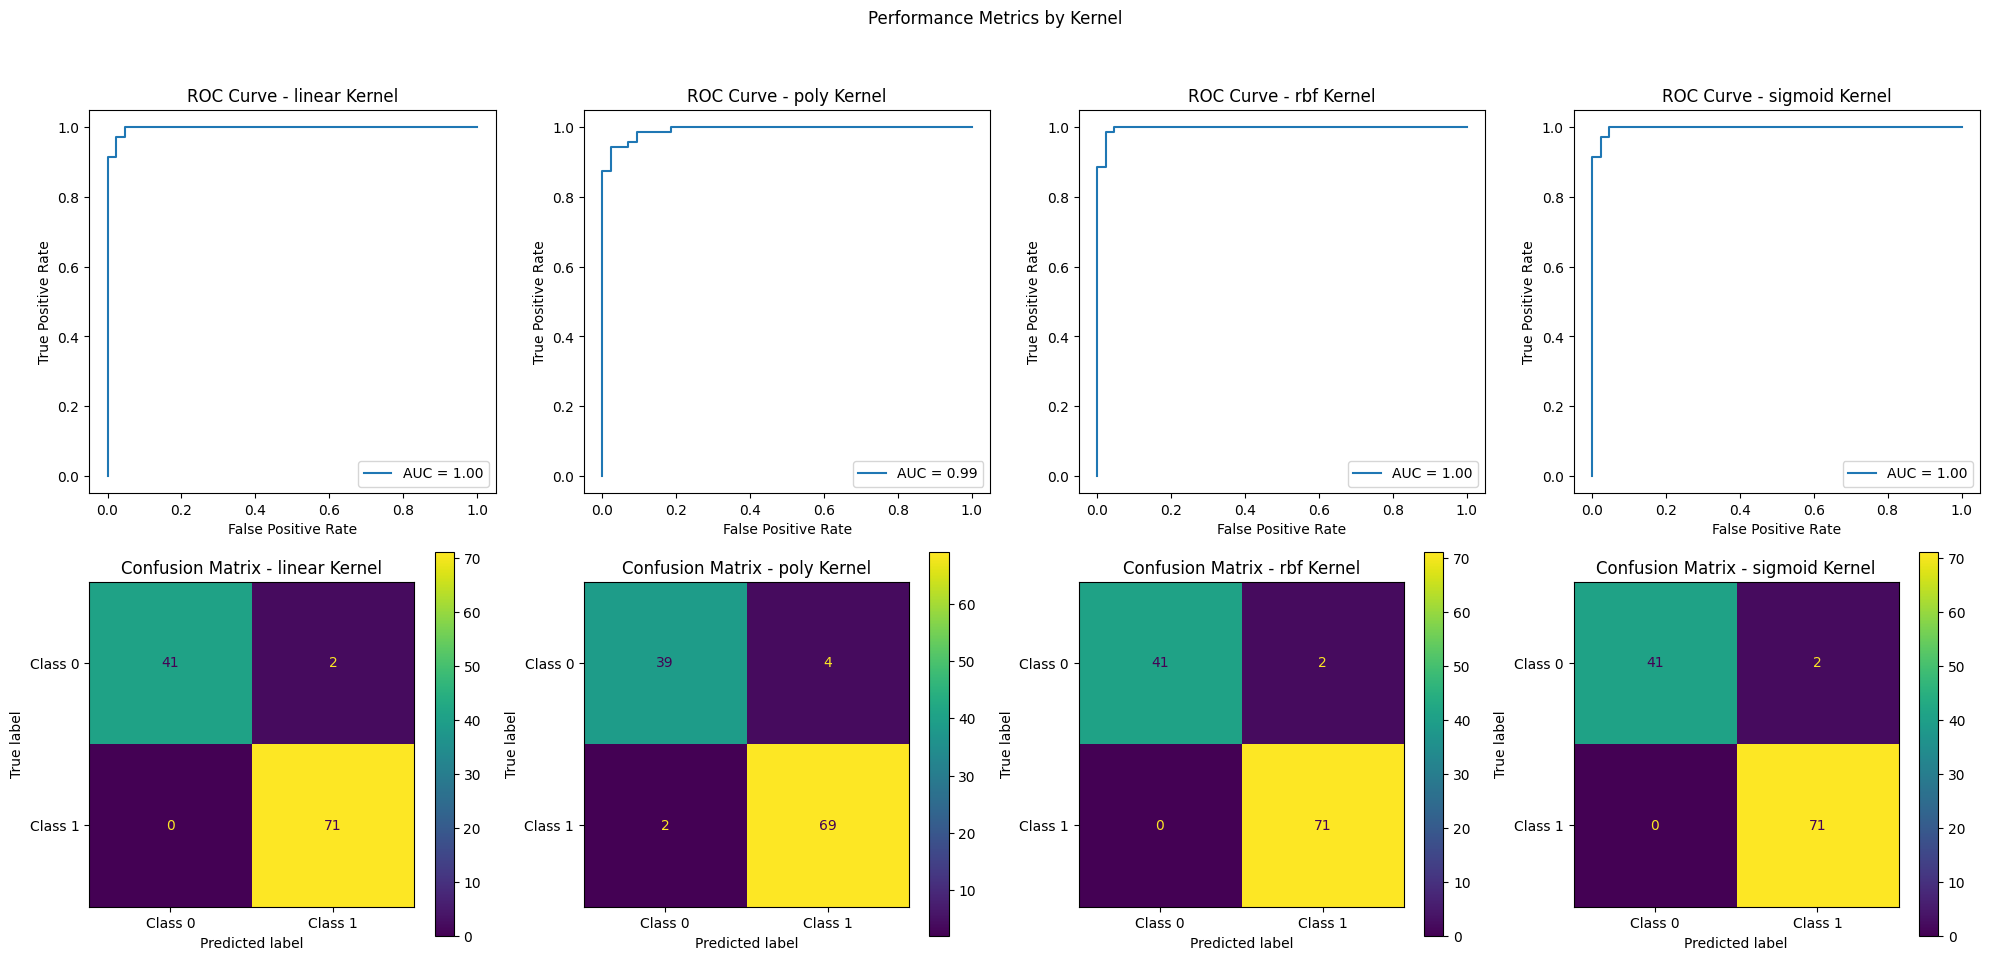

,Kernel,CPU Time,Accuracy,Recall,F1-Score,AUC
0,linear,0.955457,0.982456,1.000000,0.986111,0.997380
1,poly,0.913939,0.947368,0.971831,0.958333,0.992139
2,rbf,1.217823,0.982456,1.000000,0.986111,0.997052
3,sigmoid,0.815883,0.982456,1.000000,0.986111,0.997380


In [5]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = []

fig, axs = plt.subplots(2, 4, figsize=(20, 10)) 
fig.suptitle('Performance Metrics by Kernel')

for idx, kernel in enumerate(kernels):
    param_grid = {
        'svc__C': [0.1, 1, 10, 100],
        'svc__gamma': [0.1, 0.01, 0.001]
    }
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel=kernel, random_state=42, probability=True))
    ])
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='roc_auc')

    start_time = time.time()
    grid_search.fit(XTrain, yTrain)
    cpu_time = time.time() - start_time

    best_classifier = grid_search.best_estimator_
    yPred = best_classifier.predict(XTest)
    yPred_prob = best_classifier.predict_proba(XTest)[:, 1]

    accuracy = accuracy_score(yTest, yPred)
    recall = recall_score(yTest, yPred, average='binary') 
    f1 = f1_score(yTest, yPred, average='binary') 
    auc_score = roc_auc_score(yTest, yPred_prob)

    fpr, tpr, _ = roc_curve(yTest, yPred_prob)
    axs[0, idx].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    axs[0, idx].set_title(f'ROC Curve - {kernel} Kernel')
    axs[0, idx].set_xlabel('False Positive Rate')
    axs[0, idx].set_ylabel('True Positive Rate')
    axs[0, idx].legend(loc='lower right')

    cm = confusion_matrix(yTest, yPred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(ax=axs[1, idx]) 
    axs[1, idx].set_title(f'Confusion Matrix - {kernel} Kernel')

    results.append({
        'Kernel': kernel,
        'CPU Time': cpu_time,
        'Accuracy': accuracy,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc_score
    })

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

results_df = pd.DataFrame(results)
results_df


- Todos los kernels tienen un AUC muy cerca de 1.0, lo que indica un excelente rendimiento en la distinción entre las clases de salida. Esto es muy favorable para un conjunto de datos médicos, ya que es crucial distinguir correctamente entre casos benignos y malignos.
- Ambos kernels lineal y sigmoide tienen el AUC más alto (0.997380), lo que indica un rendimiento ligeramente superior en la clasificación comparado con los otros dos kernels.
- El kernel RBF tiene un AUC ligeramente menor (0.997052) que el lineal y sigmoide, pero aún así muy alto, lo que sugiere que también es muy competente en la clasificación.
- Aunque el kernel polinomial también tiene un buen AUC (0.992139), es el más bajo de los cuatro. Esto sugiere que, mientras que aún es muy bueno para la clasificación, puede no ser tan efectivo como los otros kernels en la separación perfecta de las clases.

Todas las métricas indican que los modelos SVM con estos cuatro kernels tienen un rendimiento excelente en este conjunto de datos. Sin embargo, los kernels lineal, rbf y sigmoide tienen un ligero margen sobre el polinomial.

## Manual

In [4]:
def customPipeline(X, y):
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    scaler = StandardScaler()
    XTrainScaled = scaler.fit_transform(XTrain)
    XTestScaled = scaler.transform(XTest)

    param_grid = {
        'linear': {'kernel': ['linear'], 'C': [0.1, 1, 10]},
        'poly': {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [2, 3, 4], 'coef0': [0, 1]},
        'sigmoid': {'kernel': ['sigmoid'], 'C': [0.1, 1, 10], 'coef0': [0, 1]},
        'rbf': {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
    }
    
    results = []

    for kernel, grid in param_grid.items():
        model = SVC()
        cv = StratifiedKFold(n_splits=5)
        grid_search = GridSearchCV(model, grid, cv=cv, scoring='recall', n_jobs=-1)
        
        grid_search.fit(XTrainScaled, yTrain)
        
        results.append({
            'Kernel': kernel,
            'Best Recall': grid_search.best_score_,
            'Best Parameters': grid_search.best_params_
        })
    
    results_df = pd.DataFrame(results)
    
    return results_df

results_df = customPipeline(X, y)
results_df

,Kernel,Best Recall,Best Parameters
0,linear,0.996491,"{'C': 0.1, 'kernel': 'linear'}"
1,poly,1.000000,"{'C': 0.1, 'coef0': 0, 'degree': 2, 'kernel': ..."
2,sigmoid,1.000000,"{'C': 1, 'coef0': 0, 'kernel': 'sigmoid'}"
3,rbf,0.978947,"{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}"


Todos los kernels han logrado un alto puntaje de recall. El recall es una métrica que indica qué tan bien el modelo puede identificar todas las instancias relevantes dentro de un conjunto de datos. Además se obtuvieron puntajes similares a los obtenidos con pipeline y grid search.

In [6]:
X, y = mglearn.datasets.load_extended_boston()

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.25, random_state=42)

param_grid = {
    'svr__C': [0.1, 1, 10, 100],          
    'svr__gamma': [0.1, 0.01, 0.001],  
    'svr__epsilon': [0.1, 0.01, 0.001]
}

results = []

for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR(kernel=kernel))
    ])

    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

    start_time = time.time()

    grid_search.fit(XTrain, yTrain)

    cpu_time = time.time() - start_time

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    yPred = best_model.predict(XTest)

    mape = mean_absolute_percentage_error(yTest, yPred)
    rmse = np.sqrt(mean_squared_error(yTest, yPred))
    r2 = r2_score(yTest, yPred)

    results.append({
        'Kernel': kernel,
        'CPU Time': cpu_time,
        'MAPE': mape,
        'RMSE': rmse,
        'R2': r2
    })

results_df = pd.DataFrame(results)
results_df


,Kernel,CPU Time,MAPE,RMSE,R2
0,linear,537.492377,0.105797,3.618059,0.813068
1,poly,29.052978,0.132806,4.037798,0.767179
2,rbf,4.214999,0.129720,3.442864,0.830733
3,sigmoid,3.585754,0.138878,4.502100,0.710556


- Kernel lineal: RMSE de 3.618059, lo que indica que este modelo tiene el mejor rendimiento entre los cuatro en términos de precisión de la predicción. Dado que su RMSE es el más bajo, los errores de predicción son, en promedio, menores que los de los otros modelos.
- Kernel polinomial (poly): RMSE de 4.037798, lo que muestra un rendimiento inferior al del kernel lineal. Los errores en las predicciones son, en promedio, más altos que los del modelo lineal.
- Kernel rbf: RMSE de 3.442864, que está cerca del modelo lineal y sugiere un buen rendimiento. Es el segundo más bajo, indicando que sus predicciones son generalmente precisas, aunque no tanto como las del kernel lineal.
- Kernel sigmoide: RMSE de 4.502100, el más alto entre los cuatro modelos, indicando que este es el modelo con el mayor error promedio en sus predicciones.

## Manual

In [11]:
def customPipeline(X, y):
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    XTrainScaled = scaler.fit_transform(XTrain)
    XTestScaled = scaler.transform(XTest)

    param_grid = {
        'linear': {'kernel': ['linear'], 'C': [0.1, 1, 10]},
        'poly': {'kernel': ['poly'], 'C': [0.1, 1, 10], 'degree': [2, 3, 4], 'coef0': [0, 1]},
        'sigmoid': {'kernel': ['sigmoid'], 'C': [0.1, 1, 10], 'coef0': [0, 1]},
        'rbf': {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
    }
    
    results = []

    for kernel, grid in param_grid.items():
        model = SVR()
        cv = KFold(n_splits=5)
        grid_search = GridSearchCV(model, grid, cv=cv, scoring='r2', n_jobs=-1)
        
        grid_search.fit(XTrainScaled, yTrain)
        
        results.append({
            'Kernel': kernel,
            'Best Score (R^2)': grid_search.best_score_,
            'Best Parameters': grid_search.best_params_
        })
    
    results_df = pd.DataFrame(results)
    
    return results_df

results_df = customPipeline(X, y)
results_df

,Kernel,Best Score (R^2),Best Parameters
0,linear,0.841680,"{'C': 1, 'kernel': 'linear'}"
1,poly,0.874684,"{'C': 10, 'coef0': 1, 'degree': 2, 'kernel': '..."
2,sigmoid,0.613865,"{'C': 1, 'coef0': 0, 'kernel': 'sigmoid'}"
3,rbf,0.810065,"{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}"


El kernel polinomial fue el que mejor rendimiento mostró según el coeficiente R^2, seguido por los kernels lineal y RBF, mientras que el kernel sigmoide tuvo el rendimiento más bajo.